# Data analysis

We would like to find statistically significant changes in the data after debris reentry. To do this we will first do the following analysis:

1. Statistical Differences (before & after reentry)
    - Mean
    - Median
    - Standard Deviation
2. Anomaly Detection
3. Range of change
4. Cumulative Unsigned Rate of Change

Finally, we will train an AI model on the data or some selected metrics and we will see how well it performs in predicting reentry events.

In [3]:
import pandas as pd

# Load the CSV file
file_path = "outputs/output.csv"
df = pd.read_csv(file_path)

# Display headers and first few rows
df_head = df.head()

# Display last few rows to get an overall sense of the data
df_tail = df.tail()

df_head, df_tail


(                  date      object    distance  distance.1  \
 0  2020-03-10T02:30:00  NORAD 6792  998.651955  998.651955   
 1  2020-03-10T05:00:00  NORAD 6792  998.651955  998.651955   
 2  2020-03-10T05:30:00  NORAD 6792  998.651955  998.651955   
 3  2020-03-10T08:30:00  NORAD 6792  998.651955  998.651955   
 4  2020-03-10T09:00:00  NORAD 6792  998.651955  998.651955   
 
    airtempsCurrentTemp  dissolvedoxygensDissolvedOxygenViaKitMgl  \
 0                 31.7                                       NaN   
 1                 29.2                                       NaN   
 2                 28.4                                       NaN   
 3                 25.4                                       NaN   
 4                 23.4                                       NaN   
 
    dissolvedoxygensDissolvedOxygenViaProbeMgl  \
 0                                         NaN   
 1                                         NaN   
 2                                         NaN   
 3  

In [4]:
# Extract the object numbers from the re-entry log
reentry_objects = set()  # Using a set for quick lookup

with open("outputs/near-reentry-log.txt", "r") as file:
    for line in file:
        parts = line.split()
        if len(parts) > 1 and parts[1].isdigit():
            reentry_objects.add(parts[1])  # Extract the object number

# Extract object numbers from the dataset
df["object_id"] = df["object"].str.extract(r'(\d+)')  # Extract numeric part of "object"
df["object_id"] = df["object_id"].astype(str)

# Find matching objects in the dataset
matching_objects = df[df["object_id"].isin(reentry_objects)]["object_id"].unique()

# Count how many re-entry objects have matching data
num_matches = len(matching_objects)
num_total = len(reentry_objects)

num_matches, num_total, matching_objects

(108,
 241,
 array(['6792', '9911', '25274', '25469', '26476', '26640', '26692',
        '27613', '28130', '28418', '28641', '28921', '29247', '29386',
        '29482', '29512', '29664', '32751', '32765', '34603', '36749',
        '38037', '38047', '38048', '38872', '38994', '39069', '39083',
        '39259', '39482', '39559', '39566', '39572', '39649', '40313',
        '40422', '40729', '40913', '40963', '41107', '41574', '41575',
        '41576', '41640', '41777', '41839', '41865', '42704', '42903',
        '42972', '43101', '43624', '43673', '43684', '44251', '44385',
        '44820', '44924', '44939', '45076', '45091', '45103', '45203',
        '45392', '45612', '45704', '45736', '46365', '46368', '46536',
        '46673', '46769', '47168', '47396', '47569', '47570', '47605',
        '47741', '47801', '47999', '48409', '48579', '48665', '48809',
        '49223', '49339', '49386', '49524', '49923', '50164', '51967',
        '52279', '52512', '52691', '53270', '53759', '53808', '5560

Now that we have the data for reentry time matched to our extracted GLOBE measurements, we can proceed with further analysis.

In [5]:
from datetime import datetime, timedelta

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])

reentry_times = {}

with open("outputs/near-reentry-log.txt", "r") as file:
    for line in file:
        parts = line.strip().rstrip(".").split()  # Remove trailing period and split
        if len(parts) > 1 and parts[1].isdigit():
            object_id = parts[1]
            timestamp_str = f"{parts[-2]} {parts[-1]}"  # Extract date and time
            try:
                reentry_times[object_id] = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
            except ValueError as e:
                print(f"Error parsing timestamp for object {object_id}: {timestamp_str} -> {e}")

# Check if parsing succeeded
len(reentry_times)

241

In [6]:
# Define time windows before and after reentry (24 and 48 hours)
time_windows = [72]

# Create dictionaries to store time series data
time_series_data = {win: {"before": [], "after": [], "distance": []} for win in time_windows}

# Extract data within the time windows
for obj_id in matching_objects:
    if obj_id in reentry_times:
        reentry_time = reentry_times[obj_id]

        for win in time_windows:
            time_before = reentry_time - timedelta(hours=win)
            time_after = reentry_time + timedelta(hours=win)

            # Select data within the time window
            before_reentry = df[(df["object_id"] == obj_id) & (df["date"] >= time_before) & (df["date"] < reentry_time)]
            after_reentry = df[(df["object_id"] == obj_id) & (df["date"] > reentry_time) & (df["date"] <= time_after)]

            time_series_data[win]["before"].append(before_reentry)
            time_series_data[win]["after"].append(after_reentry)
            time_series_data[win]["distance"].append(df[["distance", "object_id"]][df["object_id"] == obj_id])


# Concatenate results into DataFrames
for win in time_windows:
    time_series_data[win]["before"] = pd.concat(time_series_data[win]["before"])
    time_series_data[win]["after"] = pd.concat(time_series_data[win]["after"])
    time_series_data[win]["distance"] = pd.concat(time_series_data[win]["distance"])

# Display a summary of extracted data
{win: {"before_count": len(time_series_data[win]["before"]), "after_count": len(time_series_data[win]["after"]), "distance_count": len(time_series_data[win]["distance"])} for win in time_windows}


{72: {'before_count': 138388,
  'after_count': 139326,
  'distance_count': 1338657}}

In [7]:
import random

# Randomly select 5 objects from the matching ones
random_objects = random.sample(list(matching_objects), 5)

random_objects


['59592', '43684', '38048', '29247', '34603']

In [8]:
import numpy as np

# Function to compute baseline statistics for numeric columns
def compute_stats(df):
    # Select only numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    df_numeric.dropna(inplace=True, axis=1, how="all")
    
    stats = {
        "mean": df_numeric.mean(),
        "median": df_numeric.median(),
        "std_dev": df_numeric.std(),
        "IQR": df_numeric.quantile(0.75) - df_numeric.quantile(0.25),
        "range": df_numeric.max() - df_numeric.min()
    }
    return stats

# Prepare a dictionary to store the results by object
baseline_stats_by_object = {}

for win in time_windows:
    for obj_id in matching_objects:
        # Get the data for the current object
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        distance = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"].mean()
        
        if obj_id not in baseline_stats_by_object:
            baseline_stats_by_object[obj_id] = {}
        
        baseline_stats_by_object[obj_id][win] = {
            "before": compute_stats(before_data),
            "after": compute_stats(after_data),
            "distance": distance
        }


In [9]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # used to output markdown tables

def calculate_stats_series(series, trim_percentile=5):
    """Calculate statistics for a pandas Series after removing outliers based on a given percentile and return a dictionary."""
    
    # Sort the series to find the cut-off points for trimming
    series_sorted = series.sort_values()
    
    # Calculate the trim cut-off points based on the given percentile
    lower_trim = series_sorted.quantile(trim_percentile / 100)
    upper_trim = series_sorted.quantile(1 - trim_percentile / 100)
    
    # Remove outliers based on the trim values (both lower and upper)
    trimmed_series = series_sorted[
        (series_sorted >= lower_trim) & (series_sorted <= upper_trim)
    ]
    
    # Calculate statistics on the trimmed data
    stats = {
        "mean": trimmed_series.mean(),
        "median": trimmed_series.median(),
        "std_dev": trimmed_series.std(),
        "IQR": trimmed_series.quantile(0.75) - trimmed_series.quantile(0.25),
        "range": trimmed_series.max() - trimmed_series.min(),
    }
    
    return stats


# Dictionary to store the comparison tables
comparison_tables = {}

# Iterate over time windows and objects
for win in time_windows:
    for obj_id in matching_objects:
        # Filter before and after data for this object
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data  = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        distance = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"].mean()
        
        # Proceed only if there is data in both periods
        if not before_data.empty and not after_data.empty:
            # Determine which numeric measurements are available
            numeric_cols = before_data.select_dtypes(include=[np.number]).columns
            for column in numeric_cols:
                # Get the measurement series for before and after (dropping NaN)
                before_series = before_data[column].dropna()
                after_series  = after_data[column].dropna()
                
                if not before_series.empty and not after_series.empty:
                    # Compute statistics for each measurement
                    before_stats = calculate_stats_series(before_series)
                    after_stats  = calculate_stats_series(after_series)
                    
                    # Build a DataFrame for this measurement's comparison
                    comp_df = pd.DataFrame({
                        "Before": pd.Series(before_stats),
                        "After": pd.Series(after_stats)
                    })
                    comp_df.index.name = "Measurement"

                    # Add a Δ column
                    comp_df["Δ"] = comp_df["After"] - comp_df["Before"]
                    
                    # Build a table name that includes the object and measurement name
                    table_name = f"Object {obj_id} - {column} - Window {win} hours - Measured {distance}km Away"
                    comparison_tables[table_name] = comp_df

In [10]:
# Output each table in Markdown format
for table_name, df in comparison_tables.items():
    print(f"### Comparison Table: {table_name}")
    print(df.to_markdown(tablefmt="github", floatfmt=".2f"))
    print("\n")


### Comparison Table: Object 6792 - distance - Window 72 hours - Measured 998.3148785401547km Away
| Measurement   |   Before |   After |     Δ |
|---------------|----------|---------|-------|
| mean          |   998.65 |  998.65 |  0.00 |
| median        |   998.65 |  998.65 |  0.00 |
| std_dev       |     0.00 |    0.00 | -0.00 |
| IQR           |     0.00 |    0.00 |  0.00 |
| range         |     0.00 |    0.00 |  0.00 |


### Comparison Table: Object 6792 - distance.1 - Window 72 hours - Measured 998.3148785401547km Away
| Measurement   |   Before |   After |     Δ |
|---------------|----------|---------|-------|
| mean          |   998.65 |  998.65 |  0.00 |
| median        |   998.65 |  998.65 |  0.00 |
| std_dev       |     0.00 |    0.00 | -0.00 |
| IQR           |     0.00 |    0.00 |  0.00 |
| range         |     0.00 |    0.00 |  0.00 |


### Comparison Table: Object 6792 - airtempsCurrentTemp - Window 72 hours - Measured 998.3148785401547km Away
| Measurement   |   Before |

In [11]:
# Initialize a structure to hold the changes
aggregated_changes = {}

for win in time_windows:
    for obj_id in matching_objects:
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        distance = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"].mean()

        if not before_data.empty and not after_data.empty:
            numeric_cols = before_data.select_dtypes(include=[np.number]).columns

            for column in numeric_cols:
                # Drop NaN values explicitly before statistic calculations
                before_series = before_data[column].dropna()
                after_series = after_data[column].dropna()

                # Ensure we have enough data after dropping NaNs for meaningful calculations
                if len(before_series) > 1 and len(after_series) > 1:
                    before_stats = calculate_stats_series(before_series)
                    after_stats = calculate_stats_series(after_series)

                    # Handle potential NaNs in specific statistics
                    if 'std_dev' in before_stats and 'std_dev' in after_stats:
                        if np.isnan(before_stats['std_dev']) or np.isnan(after_stats['std_dev']):
                            continue  # Skip further processing for cases with NaN std_dev
                        
                    stats_difference = {key: after_stats[key] - before_stats[key] for key in before_stats}
                    
                    if column not in aggregated_changes:
                        aggregated_changes[column] = {key: [] for key in stats_difference}
                        
                    for key in stats_difference:
                        aggregated_changes[column][key].append(stats_difference[key])
# Compute aggregate statistics, e.g., mean and standard deviation of changes
for column, changes in aggregated_changes.items():
    for stat, values in changes.items():
        values_np = np.array(values)
        aggregated_changes[column][stat] = {
            "mean_change": np.mean(values_np),
            "stddev_change": np.std(values_np)
        }

# Display the aggregated changes
for column, stats in aggregated_changes.items():
    print(f"### Aggregated Changes for Measurement: {column}")
    for stat, data in stats.items():
        mean_change = data['mean_change']
        stddev_change = data['stddev_change']

        print(f"{stat}: Mean Change = {mean_change:.2f}, Std Dev of Change = {stddev_change:.2f}")
    print("\n")

### Aggregated Changes for Measurement: distance
mean: Mean Change = 3.22, Std Dev of Change = 50.05
median: Mean Change = 3.49, Std Dev of Change = 88.50
std_dev: Mean Change = -4.47, Std Dev of Change = 30.59
IQR: Mean Change = -6.57, Std Dev of Change = 62.97
range: Mean Change = -4.99, Std Dev of Change = 88.65


### Aggregated Changes for Measurement: distance.1
mean: Mean Change = 3.22, Std Dev of Change = 50.05
median: Mean Change = 3.49, Std Dev of Change = 88.50
std_dev: Mean Change = -4.47, Std Dev of Change = 30.59
IQR: Mean Change = -6.57, Std Dev of Change = 62.97
range: Mean Change = -4.99, Std Dev of Change = 88.65


### Aggregated Changes for Measurement: airtempsCurrentTemp
mean: Mean Change = 0.03, Std Dev of Change = 2.45
median: Mean Change = -0.16, Std Dev of Change = 2.81
std_dev: Mean Change = -0.30, Std Dev of Change = 1.17
IQR: Mean Change = -0.61, Std Dev of Change = 2.20
range: Mean Change = -0.76, Std Dev of Change = 3.46


### Aggregated Changes for Measure

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Data storage
hist_data = {}

for win in time_windows:
    for obj_id in matching_objects:
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        distance = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"].mean()
        
        if not before_data.empty and not after_data.empty:
            numeric_cols = before_data.select_dtypes(include=[np.number]).columns

            for column in numeric_cols:
                before_stats = calculate_stats_series(before_data[column].dropna())
                after_stats = calculate_stats_series(after_data[column].dropna())

                stats_difference = {key: after_stats[key] - before_stats[key] for key in before_stats}
                stats_difference["distance"] = distance  # Store distance
                
                if column in hist_data:
                    hist_data[column].append(stats_difference)
                else:
                    hist_data[column] = [stats_difference]

# Function to plot histograms with bin colors based on distance

def plot_histograms(data, value, pdf=None):
    for key, values in data.items():
        means = [entry[value] for entry in values if not np.isnan(entry[value])]
        distances = [entry["distance"] for entry in values if not np.isnan(entry[value])]

        if len(means) < 16:
            continue

        if means:
            fig, ax = plt.subplots(figsize=(8, 6))
            counts, bins, patches = ax.hist(means, bins=10, edgecolor='black')

            norm = mcolors.Normalize(vmin=min(distances), vmax=max(distances))
            colormap = cm.viridis
            
            for bin_patch, dist in zip(patches, distances):
                bin_patch.set_facecolor(colormap(norm(dist)))

            sm = cm.ScalarMappable(cmap=colormap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, label="Distance")
            
            ax.set_title(f"{value} Difference of {key}")
            ax.set_xlabel("Delta")
            ax.set_ylabel("Frequency")
            
            if pdf:
                pdf.savefig(fig)
                plt.close(fig)
            else:
                plt.show()

with PdfPages("outputs/histograms.pdf") as pdf:
    plot_histograms(hist_data, "mean", pdf)
    plot_histograms(hist_data, "std_dev", pdf)
    plot_histograms(hist_data, "range", pdf)
    plot_histograms(hist_data, "IQR", pdf)


## Testing hypotheses

Having seen the data, let's test some hypotheses:

Up first: Does the reentry of space debris reduce humidity variability in the local atmosphere?

We will evaluate the following: IQR, Range, and Standard Deviation

In [13]:
import numpy as np
from scipy import stats

before = {}
after = {}

# Example data: Humidity variability before and after reentry
# Replace these with actual values from your dataset
for win in time_windows:
    for obj_id in matching_objects:
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        distance = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"].mean()
        
        if not before_data.empty and not after_data.empty:
            numeric_cols = before_data.select_dtypes(include=[np.number]).columns

            for column in numeric_cols:
                before_stats = calculate_stats_series(before_data[column].dropna())
                after_stats = calculate_stats_series(after_data[column].dropna())
                if column not in before:
                    before[column] = {}
                    after[column] = {}
 
                for stat in before_stats:
                    if stat not in before[column]:
                        before[column][stat] = []
                        after[column][stat] = []
                    before[column][stat].append(before_stats[stat])
                    after[column][stat].append(after_stats[stat])

for measurement in before:
    print(f"=====================")
    print(f"Testing {measurement}")
    for stat in before[measurement]:
        print(f"Testing {stat}")

        stat_before = np.array(before[measurement][stat])
        stat_after = np.array(after[measurement][stat])
        before_filter = ~np.isnan(stat_before)
        stat_before = stat_before[before_filter]
        stat_after = stat_after[before_filter]
        after_filter = ~np.isnan(stat_after)
        stat_before = stat_before[after_filter]
        stat_after = stat_after[after_filter]

        t_stat, p_value = stats.ttest_rel(stat_before, stat_after)

        # Print results
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        # Interpretation
        alpha = 0.05  # 5% significance level
        if p_value < alpha:
            print(f"FOUND STATISTICAL SIGNIFICANCE: {measurement}: {stat} before-after difference statistically significant: P-value = {p_value}")
        else:
            print(f"{measurement}: {stat} before-after difference not statistically significant: P-value = {p_value}")


Testing distance
Testing mean
T-statistic: -0.6274
P-value: 0.5319
distance: mean before-after difference not statistically significant: P-value = 0.5318968070080936
Testing median
T-statistic: -0.3842
P-value: 0.7017
distance: median before-after difference not statistically significant: P-value = 0.7017075879669059
Testing std_dev
T-statistic: 1.4250
P-value: 0.1574
distance: std_dev before-after difference not statistically significant: P-value = 0.1574461813125528
Testing IQR
T-statistic: 1.0169
P-value: 0.3118
distance: IQR before-after difference not statistically significant: P-value = 0.3117731410375337
Testing range
T-statistic: 0.5489
P-value: 0.5844
distance: range before-after difference not statistically significant: P-value = 0.5843700927672465
Testing distance.1
Testing mean
T-statistic: -0.6274
P-value: 0.5319
distance.1: mean before-after difference not statistically significant: P-value = 0.5318968070080936
Testing median
T-statistic: -0.3842
P-value: 0.7017
distance.

/home/pisanvs/code/GLOBE-research/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/pisanvs/code/GLOBE-research/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [14]:
import numpy as np
from scipy import stats

# Dictionaries to store statistics and corresponding weights
before = {}
after = {}
weights = {}

epsilon = 1e-6  # small constant to avoid division by zero

# Loop over time windows and matching objects
for win in time_windows:
    for obj_id in matching_objects:
        # Extract data for before and after periods
        before_data = time_series_data[win]["before"][time_series_data[win]["before"]["object_id"] == obj_id]
        after_data = time_series_data[win]["after"][time_series_data[win]["after"]["object_id"] == obj_id]
        
        # Compute the mean distance for this object; then compute its weight
        distance_series = time_series_data[win]["distance"][time_series_data[win]["distance"]["object_id"] == obj_id]["distance"]
        if distance_series.empty:
            continue
        distance = distance_series.mean()
        if np.isnan(distance):
            continue
        # Inverse distance weighting: closer distances yield higher weights
        weight_val = 1 / (distance + epsilon)
        
        # Only process if both before and after data exist
        if not before_data.empty and not after_data.empty:
            numeric_cols = before_data.select_dtypes(include=[np.number]).columns

            for column in numeric_cols:
                # Compute your statistics for the column
                before_stats = calculate_stats_series(before_data[column].dropna())
                after_stats = calculate_stats_series(after_data[column].dropna())
                
                # Initialize dictionaries if not already present
                if column not in before:
                    before[column] = {}
                    after[column] = {}
                    weights[column] = {}
 
                for stat in before_stats:
                    if stat not in before[column]:
                        before[column][stat] = []
                        after[column][stat] = []
                        weights[column][stat] = []  # store corresponding weight for each pair
                    before[column][stat].append(before_stats[stat])
                    after[column][stat].append(after_stats[stat])
                    weights[column][stat].append(weight_val)

# Perform weighted paired t-tests for each measurement/statistic
for measurement in before:
    print("=====================")
    print(f"Testing {measurement}")
    for stat in before[measurement]:
        print(f"Testing {stat}")
        
        # Convert lists to numpy arrays
        stat_before = np.array(before[measurement][stat])
        stat_after = np.array(after[measurement][stat])
        w = np.array(weights[measurement][stat])
        
        # Remove any NaN values in parallel across arrays
        valid = ~np.isnan(stat_before) & ~np.isnan(stat_after) & ~np.isnan(w)
        stat_before = stat_before[valid]
        stat_after = stat_after[valid]
        w = w[valid]
        
        if len(stat_before) == 0:
            print("No valid data for this test.")
            continue
        
        # Compute paired differences
        d = stat_before - stat_after
        
        # Compute total weight and sum of squared weights
        W = np.sum(w)
        w2 = np.sum(w**2)
        if W == 0 or w2 == 0:
            print("Invalid weights, skipping test.")
            continue
        
        # Effective sample size
        n_eff = W**2 / w2
        
        # Weighted mean difference
        d_bar = np.sum(w * d) / W
        
        # Calculate weighted variance of the differences using:
        # weighted_var = sum(w * (d - d_bar)^2) / (W - (sum(w^2)/W))
        denom = W - (w2 / W)
        if denom <= 0:
            print("Non-positive denominator for weighted variance, skipping.")
            continue
        weighted_var = np.sum(w * (d - d_bar)**2) / denom
        
        # Standard error of the weighted mean difference
        se = np.sqrt(weighted_var / n_eff)
        if se == 0:
            print("Standard error zero, cannot compute t-statistic.")
            continue
        
        # Compute t-statistic and two-tailed p-value
        t_stat = d_bar / se
        p_value = 2 * stats.t.sf(np.abs(t_stat), df=n_eff - 1)
        
        # Print results
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.4f}")
        
        alpha = 0.05  # significance level (here 10% as an example)
        if p_value < alpha:
            print(f"FOUND STATISTICAL SIGNIFICANCE: {measurement}: {stat} before-after difference statistically significant (P-value = {p_value})")
        else:
            print(f"{measurement}: {stat} before-after difference not statistically significant (P-value = {p_value})")


Testing distance
Testing mean
T-statistic: -0.1899
P-value: 0.8499
distance: mean before-after difference not statistically significant (P-value = 0.8498978288704224)
Testing median
T-statistic: -0.1345
P-value: 0.8934
distance: median before-after difference not statistically significant (P-value = 0.8933892928606751)
Testing std_dev
T-statistic: 1.2747
P-value: 0.2065
distance: std_dev before-after difference not statistically significant (P-value = 0.20651676022975976)
Testing IQR
T-statistic: 0.9809
P-value: 0.3299
distance: IQR before-after difference not statistically significant (P-value = 0.3299262843377382)
Testing range
T-statistic: 0.6472
P-value: 0.5195
distance: range before-after difference not statistically significant (P-value = 0.5195269826480489)
Testing distance.1
Testing mean
T-statistic: -0.1899
P-value: 0.8499
distance.1: mean before-after difference not statistically significant (P-value = 0.8498978288704224)
Testing median
T-statistic: -0.1345
P-value: 0.8934
di

In [24]:
for win in time_windows:
    print(time_series_data[win]["before"].columns)

Index(['date', 'object', 'distance', 'distance.1', 'airtempsCurrentTemp',
       'dissolvedoxygensDissolvedOxygenViaKitMgl',
       'dissolvedoxygensDissolvedOxygenViaProbeMgl',
       'dissolvedoxygensSalinityViaDokitPpt', 'humiditiesDewpoint',
       'humiditiesRelativeHumidityPercent', 'object_id', 'condition'],
      dtype='object')


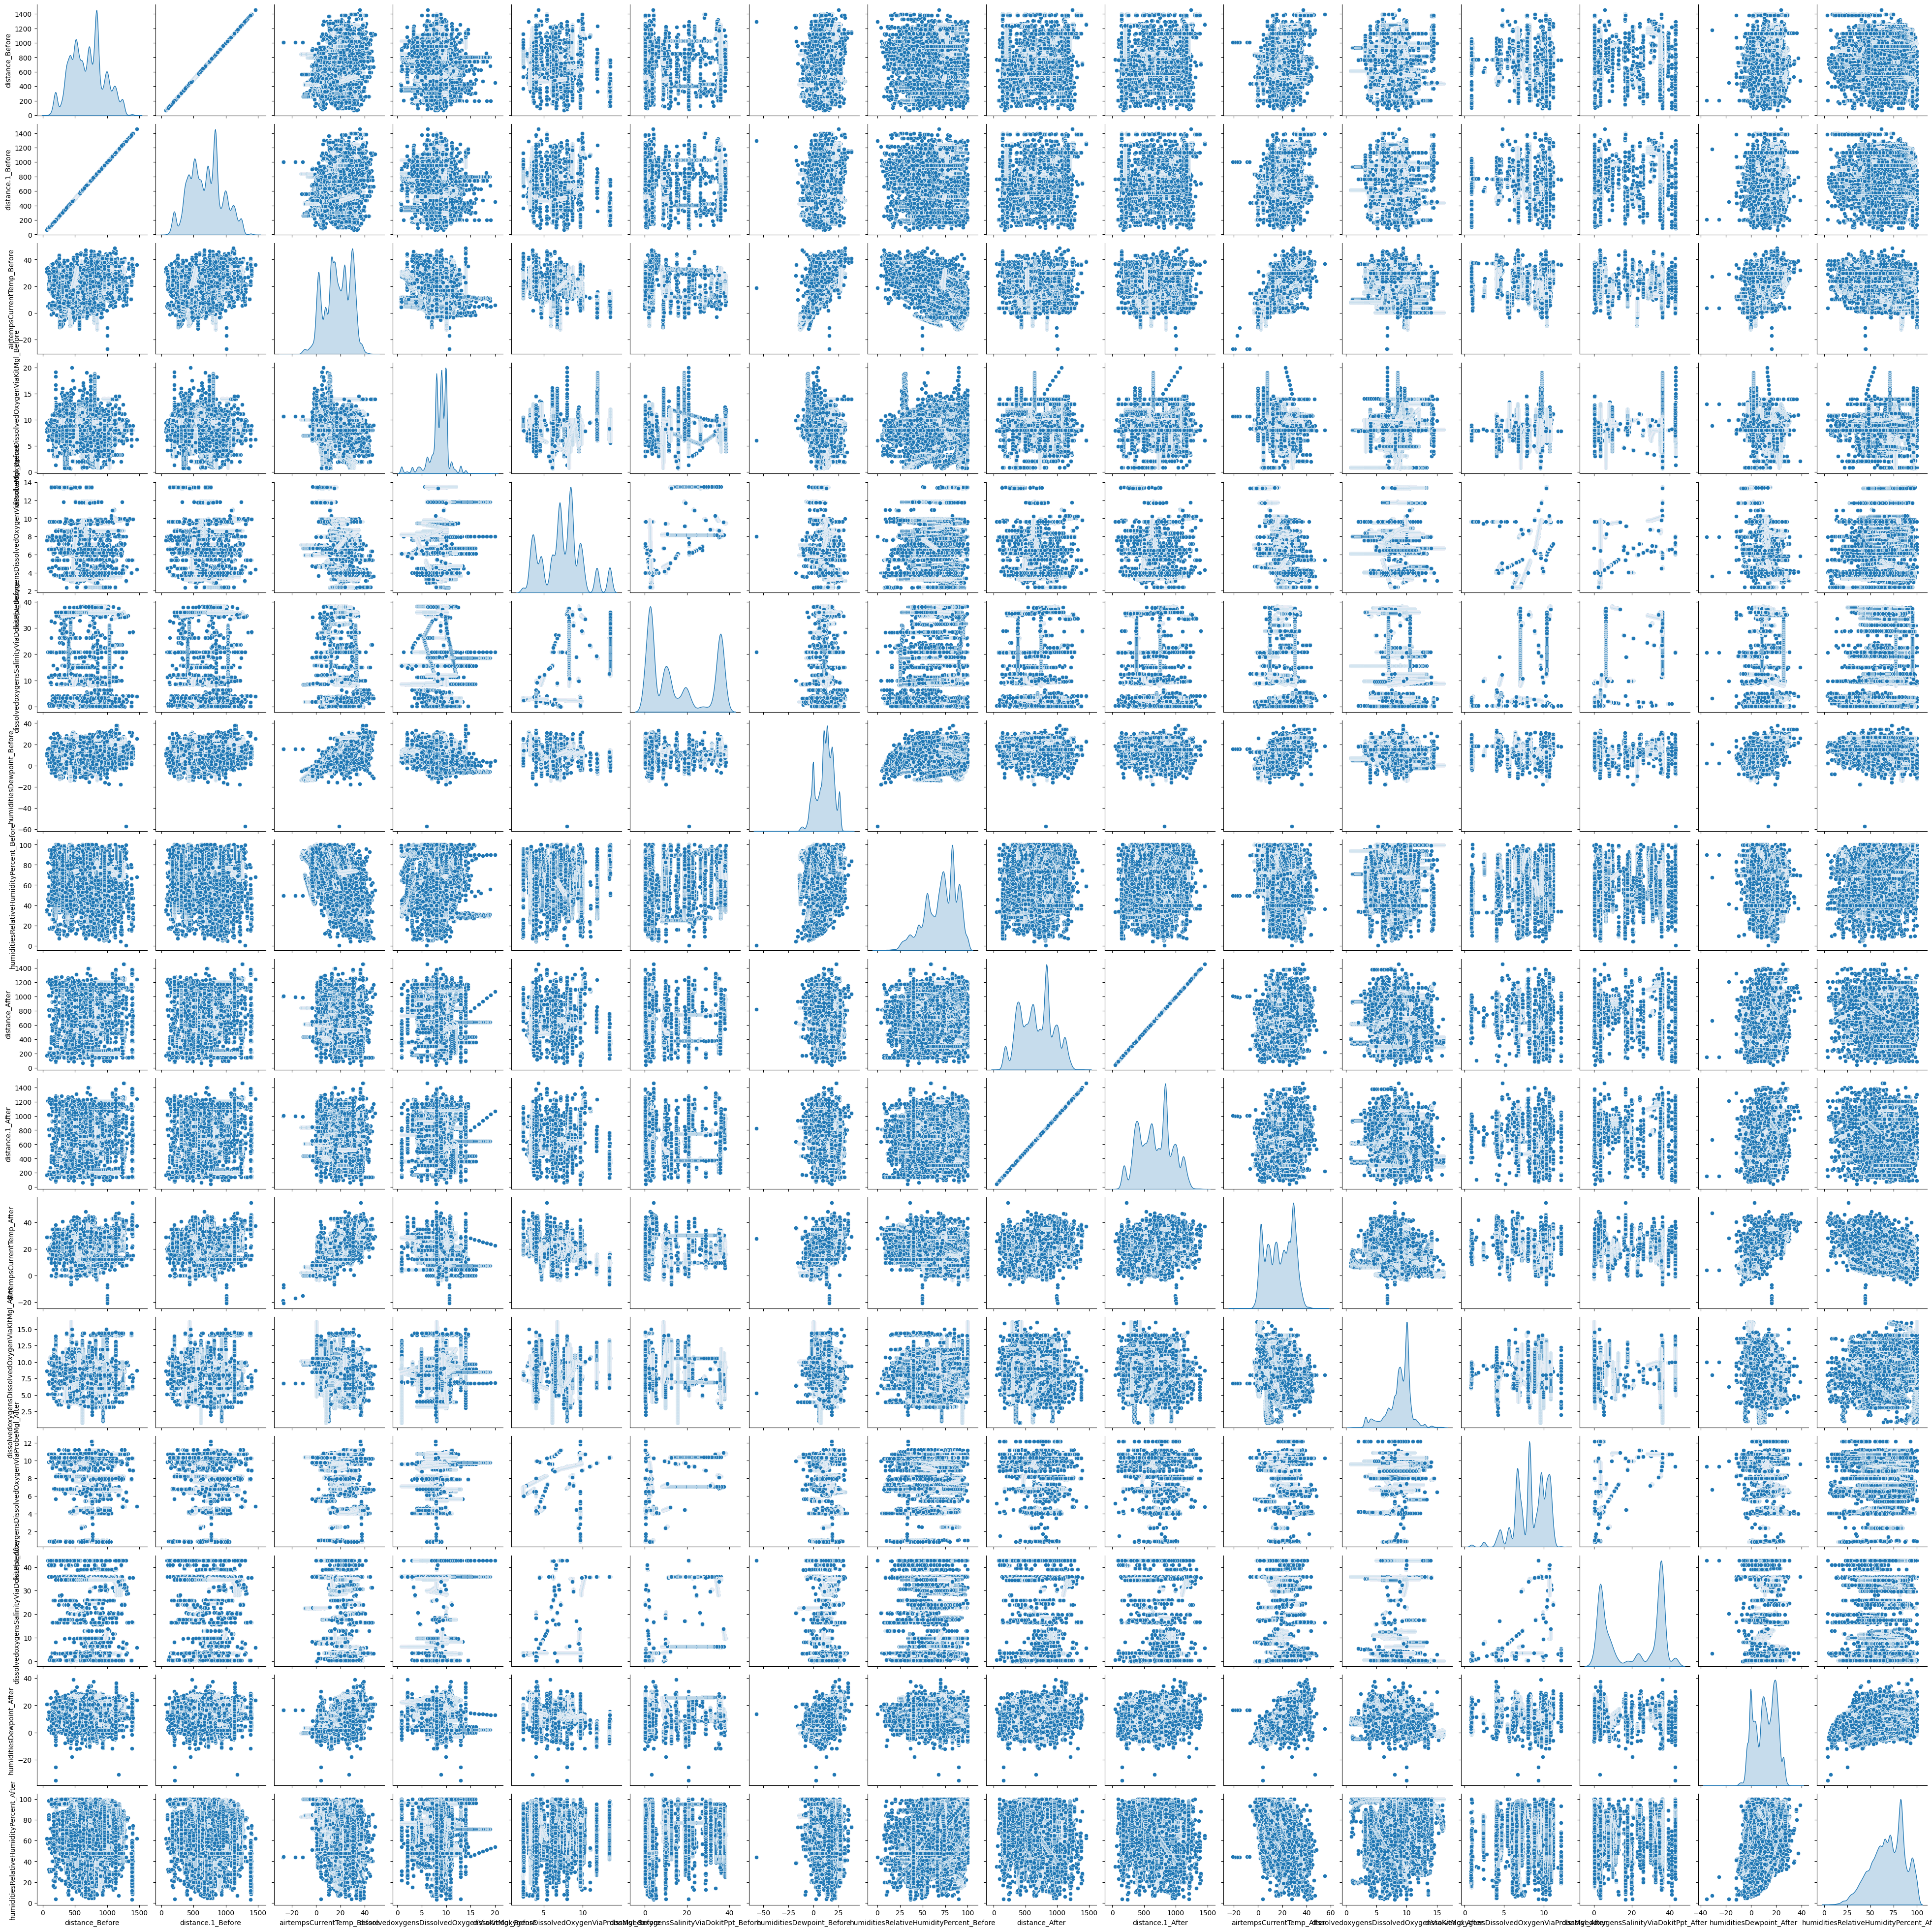

In [27]:
import seaborn as sns

for win in time_windows:
    before = time_series_data[win]["before"].copy()
    after = time_series_data[win]["after"].copy()

    # Convert the date column to datetime
    before['date'] = pd.to_datetime(before['date'])
    after['date'] = pd.to_datetime(after['date'])
    
    # Select only numeric columns (and add the date column for grouping)
    before_numeric = before.select_dtypes(include=['number']).copy()
    after_numeric = after.select_dtypes(include=['number']).copy()
    before_numeric['date'] = before['date']
    after_numeric['date'] = after['date']
    
    # Group by date to aggregate duplicate dates
    before_grouped = before_numeric.groupby('date').mean()
    after_grouped = after_numeric.groupby('date').mean()
    
    # Add suffixes to distinguish the two sets of features
    before_grouped = before_grouped.add_suffix('_Before')
    after_grouped = after_grouped.add_suffix('_After')
    
    # Concatenate the DataFrames along columns
    comparison = pd.concat([before_grouped, after_grouped], axis=1)
    
    # Interpolate using the time-based method (the index is now unique datetime)
    comparison_interpolated = comparison.interpolate(method='time')
    
    # Reset the index to bring the date back as a column
    comparison_interpolated = comparison_interpolated.reset_index()
    
    # Create the pairplot
    sns.pairplot(comparison_interpolated, diag_kind="kde")
